In [20]:
# ✅ Cek dan tampilkan versi library yang dibutuhkan
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from scipy import stats
import sklearn

print("Python:", sys.version)
print("pandas:", pd.__version__)
print("numpy:", np.__version__)
print("seaborn:", sns.__version__)
print("matplotlib:", matplotlib.__version__)
print("scipy:", stats.__package__ or "scipy")
print("sklearn:", sklearn.__version__)


Python: 3.10.18 | packaged by Anaconda, Inc. | (main, Jun  5 2025, 13:08:55) [MSC v.1929 64 bit (AMD64)]
pandas: 2.3.3
numpy: 2.2.6
seaborn: 0.13.2
matplotlib: 3.10.6
scipy: scipy.stats
sklearn: 1.7.2


In [21]:
# ==========================================================
# 📦 Upload file TSV pembelian dari folder lokal
# ==========================================================
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import re, os
from scipy import stats
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

warnings.filterwarnings("ignore", category=FutureWarning)

# ganti path dengan folder tempat file kamu
folder_path = "data"
filename = "pembelian.tsv"
file_path = os.path.join(folder_path, filename)

if not os.path.exists(file_path):
    raise FileNotFoundError(f"File '{file_path}' tidak ditemukan!")

with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
    lines = [line.rstrip("\n") for line in f.readlines()]

lines = [l for l in lines if l.strip()]
print(f"✅ File '{filename}' berhasil dibaca dengan {len(lines)} baris.")


✅ File 'pembelian.tsv' berhasil dibaca dengan 146474 baris.


In [22]:
# ==========================================================
# 🧩 Parsing Dataset Pembelian
# ==========================================================
transaksi_data, total_data = [], []
current_product = None

pattern_header_produk = re.compile(r"^([A-Z0-9]+)\s+([A-Za-z0-9\s\.\-]+?)\s+([A-Z]{2,5})\s*$")
pattern_transaksi = re.compile(
    r"^\s*(\d{2}-\d{2}-\d{2})\s+([\d\.\-]+)(\s+)([\d,.]+)\s+([\d,.]+)\s*$"
)

def clean_num(x):
    if not x: return None
    x = x.replace(".", "").replace(",", ".")
    try: return float(x)
    except: return None

KELUAR_SPACE_THRESHOLD = 18

for line in lines:
    mh = pattern_header_produk.match(line)
    if mh:
        current_product = {
            "kode": mh.group(1).strip(),
            "nama_produk": mh.group(2).strip(),
            "unit": mh.group(3).strip(),
        }
        continue

    if current_product is None or re.match(r"^\s*-{5,}\s*$", line):
        continue

    if re.match(r"^\s+[\d,]+\s+[\d,]+\s*$", line):
        nums = re.findall(r"[\d,]+", line)
        if len(nums) >= 2:
            total_data.append({
                "kode": current_product["kode"],
                "nama_produk": current_product["nama_produk"],
                "unit": current_product["unit"],
                "total_qty_masuk": clean_num(nums[0]),
                "total_qty_keluar": clean_num(nums[1]),
            })
        continue

    mt = pattern_transaksi.match(line)
    if mt:
        tanggal, no_trx, ws, qty, nilai = mt.groups()
        is_keluar = len(ws) >= KELUAR_SPACE_THRESHOLD
        qty, nilai = clean_num(qty), clean_num(nilai)
        transaksi_data.append({
            "kode": current_product["kode"],
            "nama_produk": current_product["nama_produk"],
            "unit": current_product["unit"],
            "tanggal": tanggal,
            "no_transaksi": no_trx,
            "qty_masuk": None if is_keluar else qty,
            "nilai_masuk": None if is_keluar else nilai,
            "qty_keluar": qty if is_keluar else None,
            "nilai_keluar": nilai if is_keluar else None,
        })


In [23]:
# ==========================================================
# 💾 Simpan hasil parsing ke CSV
# ==========================================================
df_transaksi = pd.DataFrame(transaksi_data)
df_total = pd.DataFrame(total_data)

df_transaksi.to_csv("pembelian_transaksi.csv", index=False)
df_total.to_csv("pembelian_total.csv", index=False)

print(f"✅ {len(df_transaksi)} baris transaksi & {len(df_total)} baris total disimpan.")
display(df_transaksi.head())


✅ 138352 baris transaksi & 1968 baris total disimpan.


,kode,nama_produk,unit,tanggal,no_transaksi,qty_masuk,nilai_masuk,qty_keluar,nilai_keluar
0,A000001,ANATON TAB,STRIP,06-07-21,1.13-210706.0908-003,10.0,2520.0,NaN,NaN
1,A000001,ANATON TAB,STRIP,12-07-21,2.6-210712.1519-097,NaN,NaN,1.0,3000.0
2,A000001,ANATON TAB,STRIP,12-07-21,2.11-210712.1633-013,NaN,NaN,1.0,3000.0
3,A000001,ANATON TAB,STRIP,12-07-21,2.13-210712.1807-013,NaN,NaN,1.0,3000.0
4,A000001,ANATON TAB,STRIP,12-07-21,2.11-210712.1855-018,NaN,NaN,1.0,3000.0


In [24]:
# ==========================================================
# ⚙️ Deteksi Outlier (Z-Score)
# ==========================================================
df = pd.read_csv("pembelian_transaksi.csv")

df["Jumlah_Beli"] = df["qty_masuk"].fillna(df["qty_keluar"])
df["Jumlah_Beli"] = pd.to_numeric(df["Jumlah_Beli"], errors="coerce")

z_scores = stats.zscore(df["Jumlah_Beli"].dropna())
z_series = pd.Series(z_scores, index=df["Jumlah_Beli"].dropna().index)
df["outlier_jumlah_beli"] = False
df.loc[z_series.index, "outlier_jumlah_beli"] = z_series.abs() > 3

print("Total outlier Jumlah_Beli:", df["outlier_jumlah_beli"].sum())


Total outlier Jumlah_Beli: 913


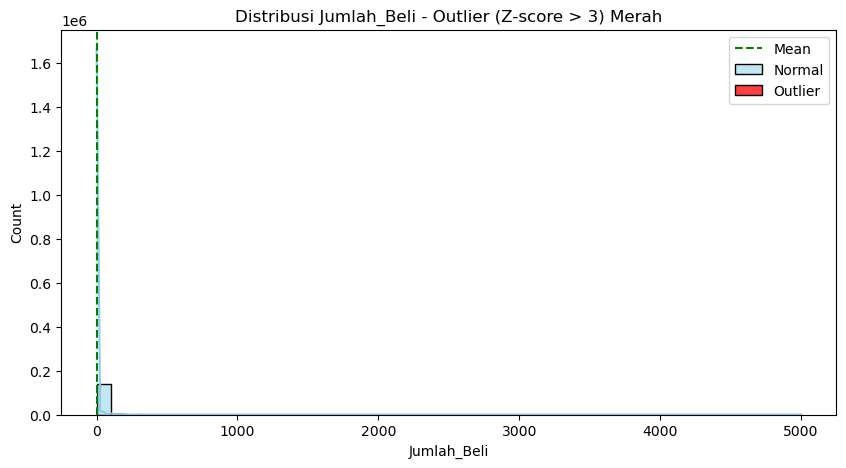

In [25]:
# ==========================================================
# 📊 Visualisasi Outlier
# ==========================================================
plt.figure(figsize=(10,5))
sns.histplot(df["Jumlah_Beli"], bins=50, kde=True, color="skyblue", label="Normal")
sns.histplot(df.loc[df["outlier_jumlah_beli"], "Jumlah_Beli"], bins=50, color="red", label="Outlier")
plt.axvline(df["Jumlah_Beli"].mean(), color='green', linestyle='--', label="Mean")
plt.title("Distribusi Jumlah_Beli - Outlier (Z-score > 3) Merah")
plt.xlabel("Jumlah_Beli")
plt.ylabel("Count")
plt.legend()
plt.show()

In [26]:
# ==========================================================
# 📈 Agregasi per Produk
# ==========================================================
agg_features = (
    df.groupby(["kode","nama_produk","unit"])
    .agg(
        trx_count=("Jumlah_Beli","count"),
        qty_sum=("Jumlah_Beli","sum"),
        qty_mean=("Jumlah_Beli","mean"),
        qty_median=("Jumlah_Beli","median"),
        qty_std=("Jumlah_Beli","std"),
        qty_max=("Jumlah_Beli","max"),
        qty_p75=("Jumlah_Beli", lambda s: s.quantile(0.75)),
        qty_p95=("Jumlah_Beli", lambda s: s.quantile(0.95))
    )
    .reset_index()
)
agg_features.fillna(0, inplace=True)

# Gabungkan informasi outlier ke level produk
outlier_per_product = df.groupby("kode")["outlier_jumlah_beli"].any().astype(int).reset_index()
agg_features = agg_features.merge(outlier_per_product, on="kode", how="left")
agg_features["outlier_jumlah_beli"] = agg_features["outlier_jumlah_beli"].fillna(0).astype(int)


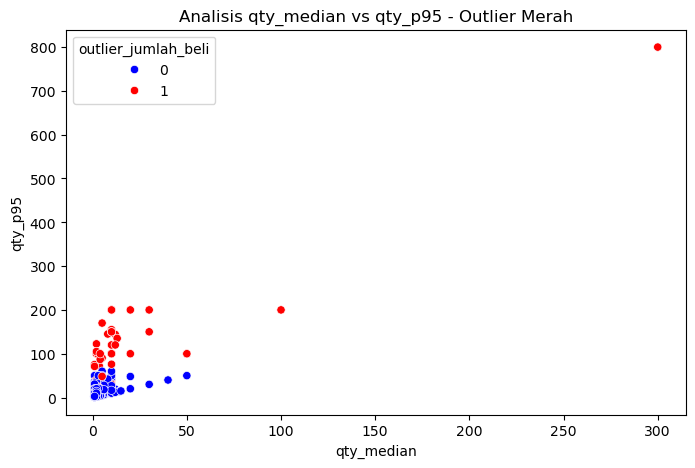

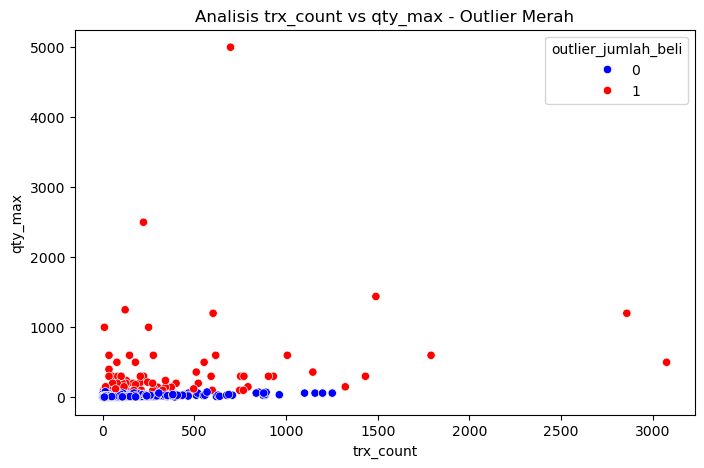

In [27]:
# ==========================================================
# 📉 Visualisasi Outlier Berdasarkan Fitur
# ==========================================================
plt.figure(figsize=(8,5))
sns.scatterplot(data=agg_features, x="qty_median", y="qty_p95",
                hue="outlier_jumlah_beli", palette={0:"blue",1:"red"})
plt.title("Analisis qty_median vs qty_p95 - Outlier Merah")
plt.show()

plt.figure(figsize=(8,5))
sns.scatterplot(data=agg_features, x="trx_count", y="qty_max",
                hue="outlier_jumlah_beli", palette={0:"blue",1:"red"})
plt.title("Analisis trx_count vs qty_max - Outlier Merah")
plt.show()


In [28]:
# ==========================================================
# 🧠 Model ML Sederhana (Prediksi Permintaan Tinggi vs Rendah)
# ==========================================================
print("\n--- Pembentukan Model (Tanpa Imputasi, hanya data lengkap) ---")

threshold = agg_features["qty_mean"].median()
agg_features["permintaan_kategori"] = (agg_features["qty_mean"] > threshold).astype(int)

X_ml = agg_features[["trx_count","qty_sum","qty_median","qty_std","qty_max","qty_p75","qty_p95"]]
y_ml = agg_features["permintaan_kategori"]

mask_complete = X_ml.notnull().all(axis=1) & y_ml.notnull()
X_ml_complete = X_ml.loc[mask_complete]
y_ml_complete = y_ml.loc[mask_complete]

X_train, X_test, y_train, y_test = train_test_split(
    X_ml_complete, y_ml_complete, test_size=0.3, random_state=42, stratify=y_ml_complete
)

scaler_ml = StandardScaler()
X_train_scaled = scaler_ml.fit_transform(X_train)
X_test_scaled = scaler_ml.transform(X_test)

rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model.fit(X_train_scaled, y_train)

y_pred = rf_model.predict(X_test_scaled)

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Akurasi:", round(accuracy_score(y_test, y_pred)*100, 2), "%")



--- Pembentukan Model (Tanpa Imputasi, hanya data lengkap) ---
Confusion Matrix:
 [[253  13]
 [  8 257]]

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.95      0.96       266
           1       0.95      0.97      0.96       265

    accuracy                           0.96       531
   macro avg       0.96      0.96      0.96       531
weighted avg       0.96      0.96      0.96       531

Akurasi: 96.05 %
Confusion Matrix:
 [[253  13]
 [  8 257]]

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.95      0.96       266
           1       0.95      0.97      0.96       265

    accuracy                           0.96       531
   macro avg       0.96      0.96      0.96       531
weighted avg       0.96      0.96      0.96       531

Akurasi: 96.05 %


In [29]:
# ==========================================================
# 💾 Simpan hasil akhir
# ==========================================================
df.to_csv("pembelian_transaksi_with_outlier_flag.csv", index=False)
agg_features.to_csv("pembelian_agregat_with_outlier_flag.csv", index=False)

# Simpan dataset tanpa outlier (final untuk analisis/prediksi)
df_final = df[df["outlier_jumlah_beli"] == False]
df_final.to_csv("pembelian_transaksi_final.csv", index=False)

print("\n✅ Hasil disimpan:")
print(" - pembelian_transaksi_with_outlier_flag.csv  → Dataset dengan kolom penanda outlier (Z-Score)")
print(" - pembelian_agregat_with_outlier_flag.csv    → Agregat dengan kolom penanda outlier")
print(" - pembelian_transaksi_final.csv              → Dataset bersih tanpa outlier, siap analisis prediksi stok obat optimal (CPMK0701)")



✅ Hasil disimpan:
 - pembelian_transaksi_with_outlier_flag.csv  → Dataset dengan kolom penanda outlier (Z-Score)
 - pembelian_agregat_with_outlier_flag.csv    → Agregat dengan kolom penanda outlier
 - pembelian_transaksi_final.csv              → Dataset bersih tanpa outlier, siap analisis prediksi stok obat optimal (CPMK0701)
